# Dealing with Text and Naive Bayes

Taken from Data Mining Spring 2019 class. Material adapted from content courtesy of Prof. Foster Provost and Prof. Panos Ipeirotis

The Naive Bayes classifier is based on the probability concept of Bayes Theorem where we find the probability of event A occuring given that B has occurred.
$$ \mathbb{P}(A \mid B) = \frac{\mathbb{P}(B \mid A)\mathbb{P}(A)}{\mathbb{P}(B)} $$

**P(A):** "prior" probability of a class. Without any evidence, what is the probaility of being in a particular class. This can be determined through 
 1. "Subjective" belief of the decision maker based on previous experience and knowledge 
 2. Prior experiments conducted using Bayes rules
 3. Unconditional probability inferred from data  
    
**P(B):** likelihood of evidence. How common is the feature representation across all the examples. Calculated from the data itself. 

**P(B|A):** Likelihood of observing evidence (particular features of example being classified) when class is A. [getting this may be difficult to measure accurately, which is why this method is sometimes difficult to use]


This is what it lookes like in terms of our familiar X and Y:

$$ \mathbb{P}(y \mid x_1, \, \ldots \, x_n) = \frac{\mathbb{P}(x_1 \mid y)\mathbb{P}(x_2 \mid y)\ldots\mathbb{P}(x_n \mid y)\mathbb{P}(y)}{\mathbb{P}(x_1)\mathbb{P}(x_2)\ldots\mathbb{P}(x_n)} $$

The denominator of the equation is the probability of observing all the features regardless of class. The numerator is the likelihood of observing all the features given a particular class. The values are obtained for each record in our dataset.

Since the denominator doesn't change for all records in our dataset, we can drop it:

$$ \mathbb{P}(y \mid x_1, \, \ldots \, x_n) \propto \mathbb{P}(y)\prod_{i = 1}^n\mathbb{P}(x_i \mid y) $$

$\propto $: left side is proportional to right side

$\prod $: similar to summation, but denotes product

If we have more than two classes, a multiclass classification problem, we need to find the class y with the maximum probability:

$$ y = \arg\max_y\left\{\mathbb{P}(y)\prod_{i = 1}^n\mathbb{P}(x_i \mid y) \right\} $$

It is **important** to note that your features MUST be independent for the Bayesian method to work, otherwise the results of your model will be invalid. [more details here](https://towardsdatascience.com/naive-bayes-classifier-81d512f50a7c)

In [1]:
# Import the libraries we will be using
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

# np.random.seed(36)

# We will want to keep track of some different roc curves, lets do that here
tprs = []
fprs = []
roc_labels = []


### Data
For this lesson, we have a new data set in `data/spam_ham.csv`. Let's take a look at what it contains. Looks like we have two features: some text (looks like an email), and a label for spam or ham. What is the distribution of the target variable?


In [3]:
## Terminal (Unix) command to view data quickly
!head -3 data/spam_ham.csv

text,spam
'Hi...I have to use R to find out the 90\% confidence-interval for the sensitivityand specificity of the following diagnostic test:A particular diagnostic test for multiple sclerosis was conducted on 20 MSpatients and 20 healthy subjects, 6 MS patients were classified as healthyand 8 healthy subjects were classified as suffering from the MS.Furthermore, I need to find the number of MS patients required for asensitivity of 1\%...Is there a simple R-command which can do that for me?I am completely new to R...Help please!Jochen-- View this message in context: http://www.nabble.com/Confidence-Intervals....-help...-tf3544217.html#a9894014Sent from the R help mailing list archive at Nabble.com.______________________________________________R-help@stat.math.ethz.ch mailing listhttps://stat.ethz.ch/mailman/listinfo/r-helpPLEASE do read the posting guide http://www.R-project.org/posting-guide.html',ham
'Francesco Poli wrote:> On Sun, 15 Apr 2007 21:24:00 +0200 Arnoud Engelfriet wrote:>

It doesn't look like that did what we wanted. Can you see why?

The data in this file is **text data**. The text data in the first column can have commas. The command line will have some issues reading this data since it will try to split on all instances of the delimeter. Ideally, we would like to have a way of **encapsulating** the first column. Note that we actually have something like this in the data. The first column is wrapped in single quotes. Python (and pandas) have more explicit ways of dealing with this:

In [3]:
data = pd.read_csv("data/spam_ham.csv", quotechar="'", escapechar="\\")

Above, we specify that fields that need to be encapsulated are done so with single quotes (`quotechar`). But, what if the text in this field uses single quotes? For example, apostrophes in words like "can't" would break the encapsulation. To overcome this, we **escape** single quotes that are actually just text. Here, we specify the escape character as a backslash (`escapechar`). So now, for example, "can't" would be written as "can\'t".

(Normally, this would involve slightly painful process of going through, finding the extra quotes, and escaping them.  A common way to find them would be to try to load the data, see where it breaks, fix the problem, and then iterate.  If there are just a few issues to fix, this can be effective.)

Let's take another look at our data.

In [4]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham
2,Stephen Thorne wrote:> What I was thinking was...,ham
3,"Hi,I have this site that auto generates an ind...",ham
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,ham


Here, the target is whether or not a record should be considered as spam. This is recorded as the string 'spam' or 'ham'. To make it a little easier for our classifier, let's recode it as `0` or `1`.

In [5]:
data['spam'] = pd.Series(data['spam'] == 'spam', dtype=int)

In [6]:
data.head()

,text,spam
0,Hi...I have to use R to find out the 90% confi...,0
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",0
2,Stephen Thorne wrote:> What I was thinking was...,0
3,"Hi,I have this site that auto generates an ind...",0
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,0


In [7]:
data.spam.mean()

0.40024660912453763

Since we are going to do some modeling, we should split our data into a training and test set.

In [8]:
X = data['text']  # These are the features
Y = data['spam']  # These are the labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.75)

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Text as features
How can we turn the large amount of text for each record into useful features?


#### Binary representation
One way is to create a matrix that uses each word as a feature and keeps track of whether or not a word appears in a document/record. You can do this in sklearn with a `CountVectorizer()` and setting `binary` to `true`. The process is very similar to how you fit a model: you will fit a `CounterVectorizer()`. This will figure out what words exist in your data.

In [9]:
binary_vectorizer = CountVectorizer(binary=True)
binary_vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

Let's look at the vocabulary the `CountVectorizer()` learned.

In [10]:
vocabulary_list = list(zip( binary_vectorizer.vocabulary_.keys(), binary_vectorizer.vocabulary_.values()) )

vocabulary_list[0:10]

[('this', 62062),
 ('one', 45373),
 ('is', 35703),
 ('being', 15750),
 ('promoted', 50047),
 ('take', 59486),
 ('advantagespecial', 11410),
 ('situation', 56262),
 ('alerttmxotrimax', 11924),
 ('are', 13713)]

Now that we know what words are in the data, we can transform our blobs of text into a clean matrix. Simply `.transform()` the raw data using our fitted `CountVectorizer()`. You will do this for the training and test data. What do you think happens if there are new words in the test data that were not seen in the training data?

In [12]:
X_train_binary = binary_vectorizer.transform(X_train)
X_test_binary = binary_vectorizer.transform(X_test)

We can take a look at our new `X_test_counts`.

In [13]:
X_test_binary

<2028x70931 sparse matrix of type '<class 'numpy.int64'>'
	with 219053 stored elements in Compressed Sparse Row format>

Sparse matrix? Where is our data?

If you look at the output above, you will see that it is being stored in a *sparse* matrix (as opposed to the typical dense matrix) that is ~2k rows long and ~70k columns. The rows here are records in the original data and the columns are words. Given the shape, this means there are ~140m cells that should have values. However, from the above, we can see that only ~220k cells (~0.15%) of the cells have values! Why is this?

To save space, sklearn uses a sparse matrix. This means that only values that are not zero are stored! This saves a ton of space! This also means that visualizing the data is a little trickier. Let's look at a very small chunk.

In [16]:
X_test_binary[0:20, 0:20].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0,

#### Applying a model
Now that we have a ton of features (since we have a ton of words!) let's try using a logistic regression model to predict spam/ham.

In [17]:
model = LogisticRegression()
model.fit(X_train_binary, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_binary)))

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Area under the ROC curve on test data = 0.991


Is this any good? What do we care about in this case? Let's take a look at our ROC measure in more detail by looking at the actual ROC curve.

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])

#tprs.append(tpr)
#fprs.append(fpr)
#roc_labels.append("Default Binary")


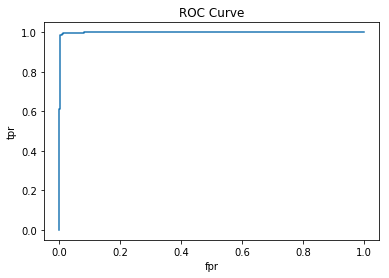

In [19]:
ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
#plt.yscale('log')
#plt.xscale('log')
plt.show()

 
**Take some time and review the curve. What do you think? Is it good? Is it bad?** 
***


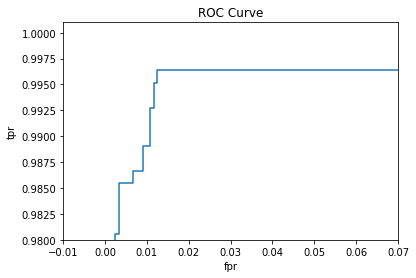

In [20]:
## lets zoom in to the graph
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_binary)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Binary")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([-0.01, .07])
plt.ylim([.98, 1.001])
plt.show()

#### Counts instead of binary
Instead of using a 0 or 1 to represent the occurence of a word, we can use the actual counts. We do this the same way as before, but now we leave `binary` set to `false` (the default value).

In [22]:
# Fit a counter
count_vectorizer = CountVectorizer()
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_counts, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Area under the ROC curve on test data = 0.993


We can also take a look at the ROC curve.

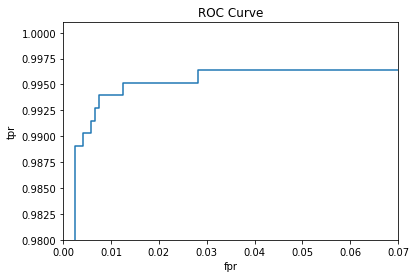

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Counts")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.xlim([0, .07])
plt.ylim([.98, 1.001])

plt.show()

#### Tf-idf
Another popular technique when dealing with text is to use tf-idf [term frequency (of the word in the document) - inverse document frequency (how many documents does the word appears in, frequency doesn’t matter)] measure instead of just counts as the feature values.
1. Accounts for the length of the document
2. Words appearing frequently in a document but not in other documents in the population, is likely to be more important
3. Inverse: the more time a word appears, the less significant it is for a specific document


In [24]:
# Fit a counter
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(X_train)

# Transform to a counter
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Model
model = LogisticRegression()
model.fit(X_train_tfidf, Y_train)

print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

/Users/Nicole/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Area under the ROC curve on test data = 0.972


Once again, we can look at the ROC curve.

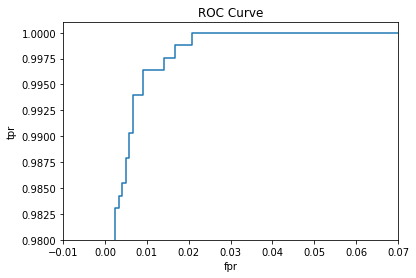

In [25]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default Tfidf")

ax = plt.subplot()
plt.plot(fpr, tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")

plt.xlim([-0.01, .07])
plt.ylim([.98, 1.001])

plt.show()

The `CountVectorizer()` and `TfidfVectorizer()` functions have many options. You can restrict the words you would like in the vocabulary. You can add n-grams. You can use stop word lists. Which options you should use generally depend on the type of data you are dealing with. We can discuss and try some of them now.

Now that we have a few different feature sets and models, let's look at all of our ROC curves.

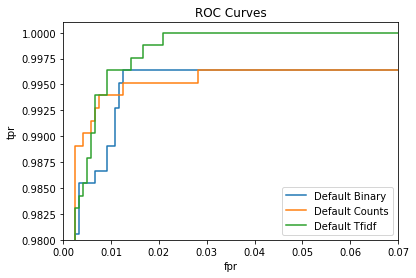

In [26]:
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.98, 1.001])

plt.show()

## Modeling with Naive Bayes

So far we have been exposed to tree classifiers and logistic regression and SVM. Now, it's time for another popular modeling technique of supervised learning(especially in text classification): the Naive Bayes (NB) classifier. There are 3 types of NB classifiers:

**1. Bernoulli Naive Bayes:**
Predictors are boolean variables. The parameters used to predict class variable only takes (1/0), whether a word occurs in a text or not for example.

**2. Multinomial Naive Bayes:**
Mostly used for document classification problem, i.e whether a document belongs to the category of sports, politics, technology etc. The features/predictors used by the classifier are the frequency of the words present in the document.

**3. Gaussian Naive Bayes:**
When the predictors are of a continuous value and are not discrete. We assume the values are sampled from a gaussian distribution.


In this example particular, we are using a Bernoulli Naive Bayes (BNB) for our binary classification. 

Again, Naive Bayes model is a **probabilistic approach which assumes conditional independence between features** (in this case, each word is a feature, the conditioning is on the true class). It assigns class labels (e.g. spam = 1 or spam = 0). In other words, Naive Bayes models the probabilities of the presence of each _word_, given that we have a spam email, and given that we have a non-spam email.  Then it combines them using Bayes Theorem (again, as described in the book).

Using this model in sklearn works just the same as the others we've seen ([More details here..](http://scikit-learn.org/stable/modules/naive_bayes.html))

- Choose the model
- Fit the model (Train)
- Predict with the model (Train or Test or Use data)

In [25]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Naive Bayes has an alpha parameter, which operates exactly like the lambda parameter for Logistic Regression
model = BernoulliNB()
model.fit(X_train_counts, Y_train)


In [29]:
print ("AUC on the count TRAIN data = %.3f" % metrics.roc_auc_score(Y_train, model.predict(X_train_counts)))
print ("AUC on the count TRAIN data = %.3f" % metrics.roc_auc_score(Y_train, model.predict_proba(X_train_counts)[:, 1]))

print ("AUC on the count TEST data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))
print ("AUC on the count TEST data = %.3f" % metrics.roc_auc_score(Y_test, model.predict_proba(X_test_counts)[:, 1]))

AUC on the count TRAIN data = 0.985
AUC on the count TRAIN data = 0.997
AUC on the count TEST data = 0.976
AUC on the count TEST data = 0.990


In [30]:
## Include the false positives and true positives to the previous list

fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_tfidf)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Default BNB")


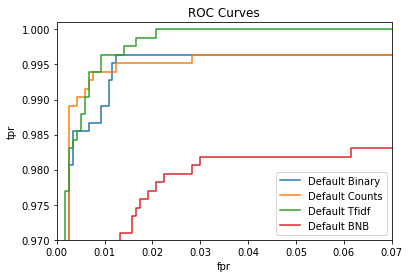

In [31]:

## Plot the list again: 3 Logistic Regressions vs Naive Bayes
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.97, 1.001])

plt.show()

In [32]:
# Fit a counter
count_vectorizer = CountVectorizer(ngram_range=(1,2))
count_vectorizer.fit(X_train)

# Transform to counter
X_train_counts = count_vectorizer.transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

# Model
model = BernoulliNB()
model.fit(X_train_counts, Y_train)

## Include the false positives and true positives to the previous list

fpr, tpr, thresholds = metrics.roc_curve(Y_test, model.predict_proba(X_test_counts)[:,1])

tprs.append(tpr)
fprs.append(fpr)
roc_labels.append("Bigram BNB")


print ("Area under the ROC curve on test data = %.3f" % metrics.roc_auc_score(Y_test, model.predict(X_test_counts)))

Area under the ROC curve on test data = 0.979


Let's see what the features are in a bigram

In [33]:
for i, k in enumerate(zip(count_vectorizer.vocabulary_.keys(), count_vectorizer.vocabulary_.values())):
    print (k)
    if i >= 10:
        break

('all', 48492)
('of', 258901)
('your', 426869)
('favorite', 148507)
('rx', 318794)
('meds', 234487)
('are', 62474)
('available', 70435)
('0nline', 4142)
('with', 417248)
('fast', 148242)


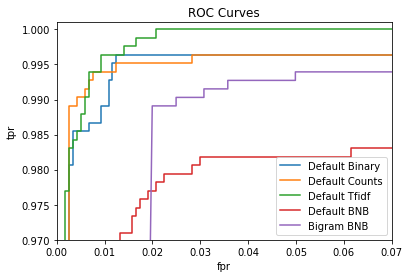

In [34]:
## Plot the list again: 3 Logistic Regressions vs Naive Bayes
for fpr, tpr, roc_label in zip(fprs, tprs, roc_labels):
    plt.plot(fpr, tpr, label=roc_label)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curves")
plt.legend()

plt.xlim([0, .07])
plt.ylim([.97, 1.001])

plt.show()

### Takeaways
Naive Bayes algorithms focuses on the idea that we assume some prior knowledge of our sample poulation and uses probablistic methods to infer class probability. A Naive Bayes classifier assumes that the presence (or absence) of a particular feature of a class is unrelated to the presence (or absence) of any other feature, given the class variable. Basically, it's "naive" because it makes assumptions that may or may not turn out to be correct.

**Advantages**
- Very simple and efficient in terms of storage space and computational time. Training consists of storing counts of classes and occurences of features
- Incremental learner: the model can be updated easily as new training data comes in without a need to retrain or reprocess all prior data 
- Useful for sentiment analysis, spam filtering, recommendation systems etc.


**Disadvantages**
- The predictors must be independent for the class probability estimates to be accurate. If two predictors are correlated, you are basically double counting the effect that they have on each other as extra evidence for a particular class


## PRACTICE EXERCISE
## 1. Get text data
## 2. Vectorize data
## 3. Apply appropriate model 
## 4. Evaluate model 

In [31]:
data 

,text,spam
0,Hi...I have to use R to find out the 90% confi...,ham
1,"Francesco Poli wrote:> On Sun, 15 Apr 2007 21:...",ham
2,Stephen Thorne wrote:> What I was thinking was...,ham
3,"Hi,I have this site that auto generates an ind...",ham
4,Author: metzeDate: 2007-04-16 08:20:13 +0000 (...,ham
5,Mandy Barron wrote:> Hello> I am having proble...,ham
6,"On Apr 15, 2007, at 6:38 PM, Mário Gamito wrot...",ham
7,Alek Storm (via RT) wrote:> The following code...,ham
8,"On Sun, Apr 15, 2007 at 09:35:45PM -0300, Andr...",ham
9,Which `gam' are you using? If it's mgcv::gam t...,ham


In [32]:
data = pd.read_csv("./data/spam_ham.csv", escapechar="\\",quotechar="'")

data['spam'] = np.where(data['spam'] == 'spam',1,0)
 
X = data['text']
y = data['spam']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

## Vectorize
tfidf = TfidfVectorizer()
tfidf.fit(X_train)

## Transform
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

## Model
log_reg = MultinomialNB()
log_reg.fit(X_train_tfidf, y_train)

## Threshold
fpr, tpr, thresholds = metrics.roc_curve(y_test, log_reg.predict_proba(X_test_tfidf)[:,1])


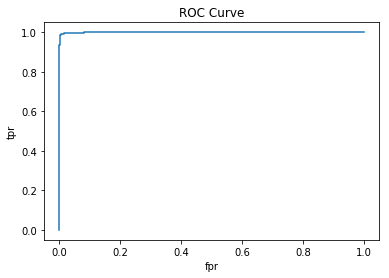

In [33]:
## plot
ax = plt.subplot()
plt.plot(fpr,tpr)
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.show()